Enter the stock ticker (e.g., AAPL, MSFT, TSLA): AAPL

Daily P/E Ratio for AAPL (Past 12 Months)
              Price TTM_EPS PE_Ratio
Date                                
2024-12-26  $257.85    6.59    39.13
2024-12-27  $254.44    6.59    38.61
2024-12-30  $251.06    6.59    38.10
2024-12-31  $249.29    7.47    33.37
2025-01-02  $242.75    7.47    32.50
2025-01-03  $242.26    7.47    32.43
2025-01-06  $243.90    7.47    32.65
2025-01-07  $241.12    7.47    32.28
2025-01-08  $241.61    7.47    32.34
2025-01-10  $235.78    7.47    31.56
2025-01-13  $233.34    7.47    31.24
2025-01-14  $232.23    7.47    31.09
2025-01-15  $236.80    7.47    31.70
2025-01-16  $227.23    7.47    30.42
2025-01-17  $228.94    7.47    30.65
2025-01-21  $221.64    7.47    29.67
2025-01-22  $222.82    7.47    29.83
2025-01-23  $222.65    7.47    29.81
2025-01-24  $221.78    7.47    29.69
2025-01-27  $228.83    7.47    30.63
2025-01-28  $237.19    7.47    31.75
2025-01-29  $238.28    7.47    31.90
2025-01-30  $23

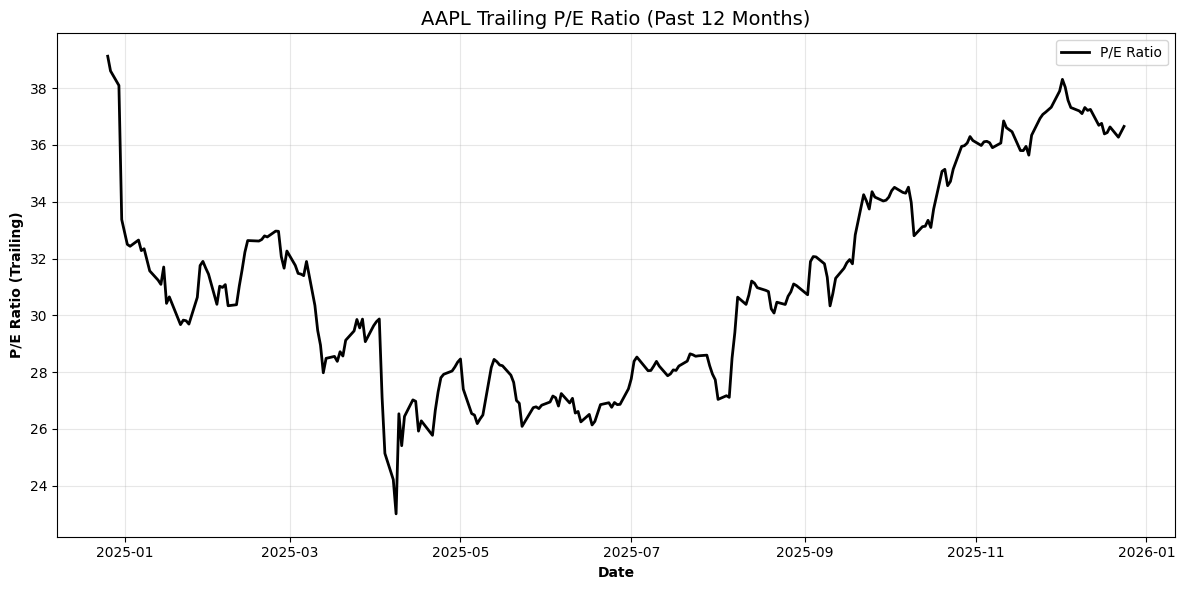

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Asks user to input a ticker
ticker_symbol = input("Enter the stock ticker (e.g., AAPL, MSFT, TSLA): ").upper()
ticker_data = yf.Ticker(ticker_symbol)

# Obtain the stock prices of the ticker
end_date = datetime.now()
start_date = end_date - timedelta(days=450)
price_history = ticker_data.history(start=start_date, end=end_date).tz_localize(None)

# Obtain historical quarterly EPS
income_stmt = ticker_data.quarterly_income_stmt

# Prioitize obtaining diluted EPS, exit if no EPS found
try:
    if 'Diluted EPS' in income_stmt.index:
        eps_quarterly = income_stmt.loc['Diluted EPS']
    elif 'Basic EPS' in income_stmt.index:
        eps_quarterly = income_stmt.loc['Basic EPS']
    else:
        raise ValueError("EPS data not found for this ticker.")

    # Calculate trailing 12-months EPS
    eps_ttm = eps_quarterly.rolling(window=4).sum().dropna()
    eps_ttm.index = pd.to_datetime(eps_ttm.index)
    eps_ttm = eps_ttm.sort_index()

    # Merge price and EPS data
    df = pd.DataFrame(price_history['Close'])
    df.columns = ['Price']
    df['TTM_EPS'] = eps_ttm.reindex(df.index, method='ffill')

    # Claculate PE Ratio
    df['PE_Ratio'] = df['Price'] / df['TTM_EPS']

    # Filter for the past 12 months
    one_year_ago = datetime.now() - timedelta(days=365)
    final_table = df[df.index >= one_year_ago].copy()

    # Generate a table of all observations
    display_table = final_table.copy()
    display_table['Price'] = display_table['Price'].map('${:,.2f}'.format)
    display_table['TTM_EPS'] = display_table['TTM_EPS'].map('{:,.2f}'.format)
    display_table['PE_Ratio'] = display_table['PE_Ratio'].map('{:,.2f}'.format)

    with pd.option_context('display.max_rows', None):
      print(f"\nDaily P/E Ratio for {ticker_symbol} (Past 12 Months)")
      print(display_table[['Price', 'TTM_EPS', 'PE_Ratio']])

    # Generate a plot based on the table
    plt.figure(figsize=(12, 6))
    plt.plot(final_table.index, final_table['PE_Ratio'], color='black', linewidth=2, label='P/E Ratio')

    plt.title(f'{ticker_symbol} Trailing P/E Ratio (Past 12 Months)', fontsize=14)
    plt.xlabel('Date', fontweight='bold')
    plt.ylabel('P/E Ratio (Trailing)', fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{ticker_symbol.lower()}_pe_time_series.png')
    plt.show()

except Exception as e:
    print(f"Error: Could not retrieve or process data for {ticker_symbol}. {e}")